In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Acquire the data

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


## EDA

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


#### Show Images

Use the PIL (Python Imaging Library) library to print images under a python console. They need to be in a 'printable' format like jpeg, png etc

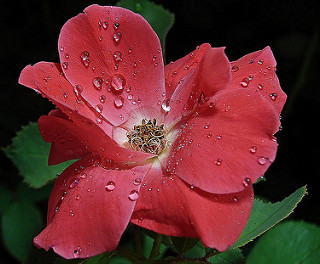

In [4]:
# Printing some roses from Roses folder under the data
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

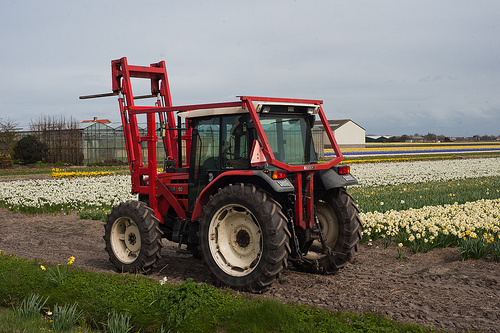

In [5]:
# And, some tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Convert Images to TF Dataset using Keras

In [6]:
# Define user inputs

batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Create the training dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
                                                        data_dir,
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=123,
                                                        image_size=(img_height, img_width),
                                                        batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
                                                      data_dir,
                                                      validation_split=0.2,
                                                      subset="validation",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# Print class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [10]:
# Let's understand the data array wise

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The output is (32, 180, 180, 3) - 

32 - Batch Size

180 - Height

180 - Width

3 - Number of color channels (3 for RGB)

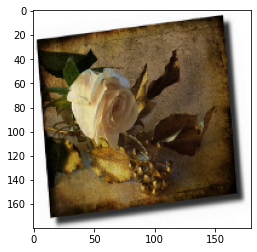

In [11]:
# Let's print 1st image in the batch
# Notice how we use Matplotlib to print an array of an image
plt.imshow(tf.keras.preprocessing.image.array_to_img(image_batch[0]))

## Performance Tuning : Dataset

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

### Rescaling Layer

Before we start off creating the model, let's explore rescaling - 

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
# In case we want to apply the rescaling directly to the dataset, we can map the lambda function to the dataset

normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y))

image_batch, label_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# First few rows of the array
print(first_image[0][0:5], label_batch[0])

# Min and Max value in the image array
print(np.min(first_image), np.max(first_image))

tf.Tensor(
[[0.8787946  0.31610748 0.1814815 ]
 [0.8938127  0.45041397 0.24496734]
 [0.85413224 0.37898332 0.24819174]
 [0.8813508  0.4093537  0.23639798]
 [0.8383007  0.5090197  0.315817  ]], shape=(5, 3), dtype=float32) tf.Tensor(4, shape=(), dtype=int32)
0.0 1.0


In [ ]:
# The other way would be to just add a Rescaling layer in the model. We use that approach

### Define the model

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [27]:
num_classes = len(class_names) #train_ds.class_names

model = Sequential([
                    layers.Rescaling(1./255 , input_shape = (img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation = 'relu'),
                    layers.Dense(num_classes)
])

### Compile the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 91s 974ms/step - loss: 1.4386 - accuracy: 0.3781 - val_loss: 1.1988 - val_accuracy: 0.4905
Epoch 2/10
92/92 [==============================] - 88s 957ms/step - loss: 1.0784 - accuracy: 0.5753 - val_loss: 0.9839 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 88s 957ms/step - loss: 0.8766 - accuracy: 0.6642 - val_loss: 0.9438 - val_accuracy: 0.6253
Epoch 4/10
92/92 [==============================] - 88s 962ms/step - loss: 0.7256 - accuracy: 0.7309 - val_loss: 0.9462 - val_accuracy: 0.6322
Epoch 5/10
92/92 [==============================] - 89s 964ms/step - loss: 0.4659 - accuracy: 0.8386 - val_loss: 1.2568 - val_accuracy: 0.5926
Epoch 6/10
92/92 [==============================] - 89s 963ms/step - loss: 0.3077 - accuracy: 0.8951 - val_loss: 1.1713 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 89s 967ms/step - loss: 0.1619 - accuracy: 0.9496 - val_loss: 1.3215 - val_accuracy: 0.6553

### Visualize training results

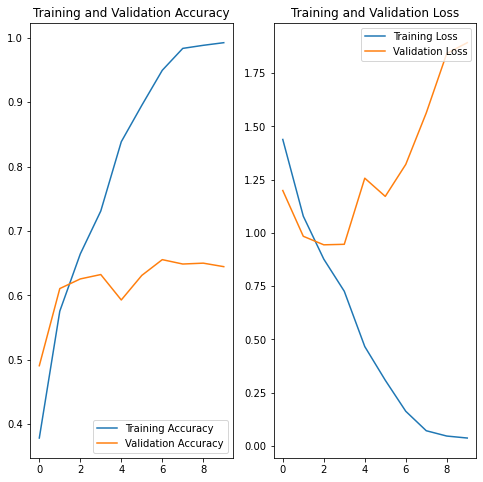

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Boy that model overfit a lot !!!!